## My Experiments with using GlobalMaxPooling2D() instead of Flatten()

Since we are loosing the spatial information when we are using Flatten(), I decided to try a different approach to connect the last convolutional layer with the first last layer that must have 4 nodes (we have 3 target classes).

I am using the same training and validation (hold out) data sets as I used in the previous notebook. 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [72]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
with open('training_64_dublicated_data.pickle', 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')

In [4]:
with open('validation_64.pickle', 'rb') as fo:
        validation_data = pickle.load(fo, encoding='bytes')

In [5]:
x = data[b'data']
x = np.array(x)
x = x.reshape(-1,64,64,3)

labels = data[b'labels']

In [6]:
x.shape

(2188, 64, 64, 3)

In [7]:
labels = data[b'labels']

In [8]:
df = pd.DataFrame(data)

### Training / testing data

b'Type_3'    810
b'Type_2'    703
b'Type_1'    675
Name: b'labels', dtype: int64

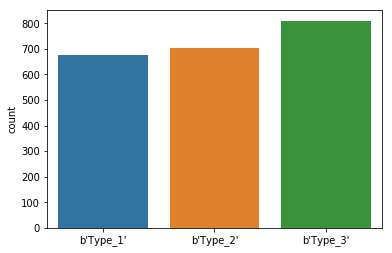

In [9]:
g = sns.countplot(labels)
df[b'labels'].value_counts()

Our classes are balanced now.

In [10]:
x_val = validation_data[b'data']
x_val = np.array(x_val)
x_val = x_val.reshape(-1,64,64,3)

labels_val = validation_data[b'labels']
x_val.shape

(148, 64, 64, 3)

In [11]:
df_val = pd.DataFrame(validation_data)

### Validation Data

b'Type_2'    78
b'Type_3'    45
b'Type_1'    25
Name: b'labels', dtype: int64

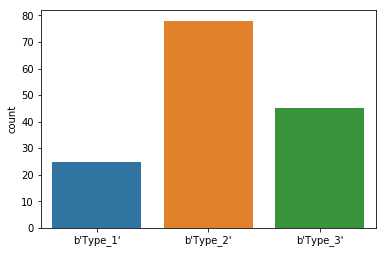

In [12]:
g = sns.countplot(labels_val)
df_val[b'labels'].value_counts()

Our validation set has the same proportion of the images to differen type as all original data. 

### Training Preparation

In [13]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)

Type_1 is "0", Type_2 is "1", Type_3 is "2"

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(x, labels, test_size = 0.1, random_state=101)

In [16]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_test)

In [17]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
X_train.shape

(1969, 64, 64, 3)

In [19]:
X_test.shape

(219, 64, 64, 3)

In [20]:
Y_train = to_categorical(Y_train,num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

## Model  

In [116]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
#model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(256, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dropout(0.2))


#model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "sigmoid"))

In [117]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [118]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 256)       8448      
__________

In [27]:
datagen = ImageDataGenerator(rotation_range=45,width_shift_range=0.1,height_shift_range=0.1,
                             zoom_range=0.3, horizontal_flip=True)
datagen.fit(X_train)

In [119]:
epochs = 20 # I tried more epachs, but we have overfitting after about 20 epochs
batch_size = 16

#fit_generator(self, generator, steps_per_epoch, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, initial_epoch=0)

history = model.fit_generator(
    datagen.flow(X_train,Y_train),
    epochs=epochs,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_data = (X_test,Y_test))

Epoch 1/20
123/123 [==============================] - 45s - loss: 1.0960 - acc: 0.3730 - val_loss: 1.0974 - val_acc: 0.3379
Epoch 2/20
123/123 [==============================] - 44s - loss: 1.0938 - acc: 0.3736 - val_loss: 1.0931 - val_acc: 0.3927
Epoch 3/20
123/123 [==============================] - 41s - loss: 1.0890 - acc: 0.3857 - val_loss: 1.0893 - val_acc: 0.3836
Epoch 4/20
123/123 [==============================] - 42s - loss: 1.0856 - acc: 0.3829 - val_loss: 1.0837 - val_acc: 0.3927
Epoch 5/20
123/123 [==============================] - 48s - loss: 1.0818 - acc: 0.3968 - val_loss: 1.0774 - val_acc: 0.3881
Epoch 6/20
123/123 [==============================] - 45s - loss: 1.0794 - acc: 0.4006 - val_loss: 1.0812 - val_acc: 0.3973
Epoch 7/20
123/123 [==============================] - 46s - loss: 1.0789 - acc: 0.3873 - val_loss: 1.0694 - val_acc: 0.3927
Epoch 8/20
123/123 [==============================] - 44s - loss: 1.0731 - acc: 0.4037 - val_loss: 1.0639 - val_acc: 0.3881
Epoch 9/

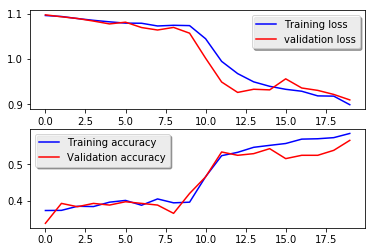

In [120]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [121]:
model.evaluate(X_train,Y_train, batch_size=2)

1964/1969 [============================>.] - ETA: 0s

[0.86058874612171798, 0.60538344337227024]

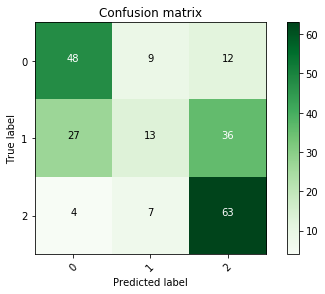

In [122]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [123]:
model.evaluate(X_test,Y_test, batch_size=2)

212/219 [============================>.] - ETA: 0s

[0.90961527422955046, 0.56621004566210043]

In [124]:
print(classification_report(Y_true, Y_pred_classes))

             precision    recall  f1-score   support

          0       0.61      0.70      0.65        69
          1       0.45      0.17      0.25        76
          2       0.57      0.85      0.68        74

avg / total       0.54      0.57      0.52       219



### Validation Data

In [36]:
encoder = LabelEncoder()
encoder.fit(labels_val)
labels_val = encoder.transform(labels_val)

Y_val = to_categorical(labels_val, num_classes=3)

In [37]:
len(Y_val)

148

In [38]:
x_val = x_val/255.0

In [39]:
len(x_val)

148

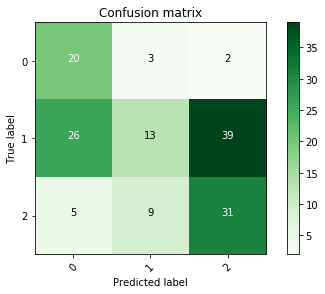

In [125]:
Y_pred_val = model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred_val,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [126]:
model.evaluate(x_val, Y_val, batch_size=2)

138/148 [==========================>...] - ETA: 0s

[1.0087256886669107, 0.43243243243243246]

In [115]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

             precision    recall  f1-score   support

          0       0.41      0.56      0.47        25
          1       0.59      0.33      0.43        78
          2       0.49      0.76      0.59        45

avg / total       0.53      0.50      0.48       148



# Results

### Network structure.
The model is the almost the same as I used with Flatten(), but I replace last pooling and  Flatten() by Conv2D(256, (1,1)) and GlobalMaxPooling2D(). 

Flatten() just create a flatt array form the previos layer, but GlobalMaxPooling2D() takes the maximum value form every filter on previouse layer. In my case in returns 256 values.

Now my model is:

* Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,3))
* MaxPool2D(pool_size=(2,2))

* Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu')
* MaxPool2D(pool_size=(2,2))

* Dropout(0.2)

* Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu')
* MaxPool2D(pool_size=(2,2))

* **Conv2D(256, (1,1))**
* **GlobalMaxPooling2D()**

* Dropout(0.2)

* Dense(32, activation='relu')
* model.add(Dropout(0.1)
* Dense(3, activation = "sigmoid")


The result is not better than when I used Faltten(), but I think it is because I have very few data. It looks like that using GlobalMaxPooling2D() instead of Flatten() gives us the overfitting. 

### The training and testing results
During the training I used a testing set to validate the accuracy of the model. Testing and training sets have about same number of images for every type of cancer. Some of images were duplicated since I wanted to have roundly same number of images for every class.  

|            | loss with Flatten() | accuracy with Flatten() | loss with GlobalMaxPooling2D() | accuracy with GlobalMaxPooling2D()  
| ------------- | ------------- |----------------
| training  | 0.796  | 0.652 |0.861 | 0.606
| testing   | 0.880  | 0.566 | 0.909 | 0.566
|hold out validation set | 0.899 | 0.547 | 1.008 | 0.432

### Possible improvements 

1. Use more sophisticated image preprocessing. The images have very different shapes. Also, a lot of image have large black "background". It could be great to select only "informative" part from all images. 

3. Get more data, use better resolution, and add more convolutional layers! I have only 4 GB memory and I am not able to download additional training samples. Thus, I decided to use low resolution (64 by 64) and only 3 layers to prevent overfitting. 

3. Try more different models archtecture (numbers of layers, filters, poolings)

## Conclusion

CNN works well for this type of problem. It is very computational effective. When I tried to use DNN I was able to use only black/withe images and 1 hidden layer. 

Also, I like that CNN prevent spatial information - every kernel "looks" at a part of image, not just a flat array.